<a href="https://colab.research.google.com/github/Basu8971/Materraproject/blob/main/MOdel-End%20season.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final selected features used in the model: ['HeatUnit3', 'NDVI3-Cum', 'PRVI-Cum-quarter3', 'CumulativePPT']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Hyperparameters for RandomForestRegressor: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


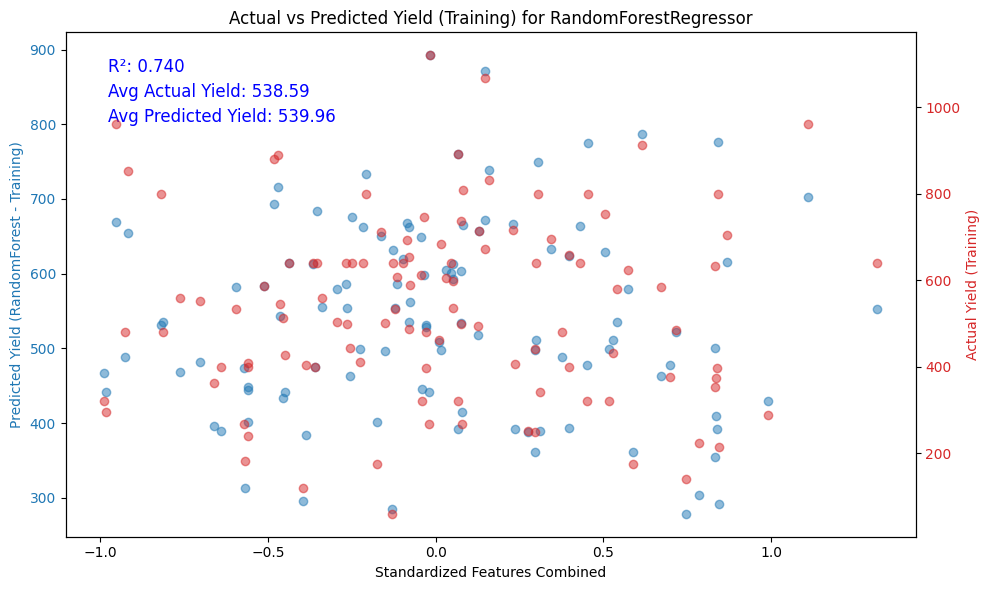

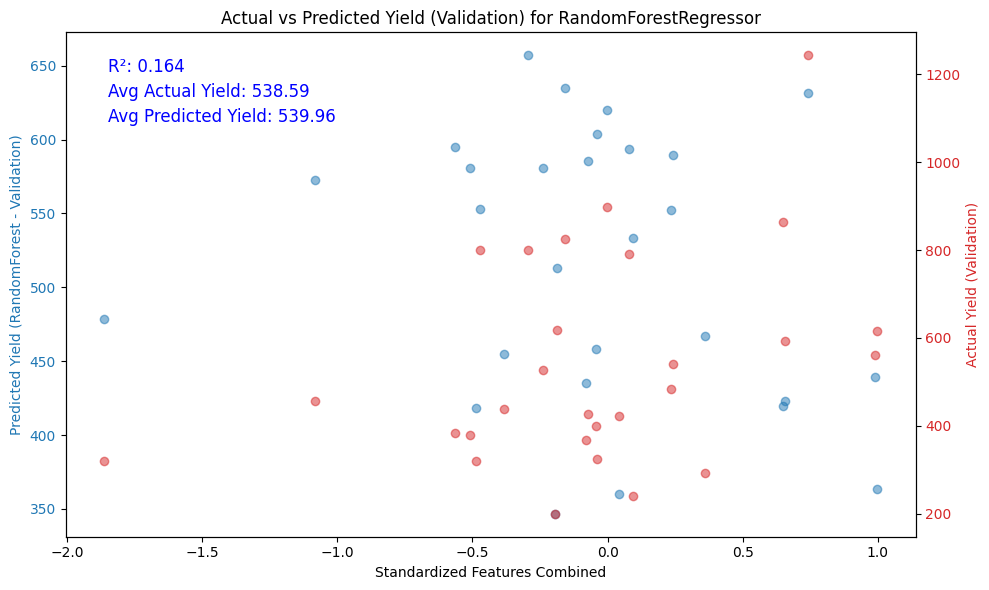

In [81]:
import pandas as pd
import gspread
from google.auth import default
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and connect to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets
def load_data_from_google_sheet(sheet_url):
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# URL for the Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data from the Google Sheets
data = load_data_from_google_sheet(sheet_url)

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Feature Selection based on Random Forest and correlation
correlation_matrix = data[features].corr()
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Feature Importance from Random Forest
X = data[features]
y = data[target]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

# Drop features with high correlation and low importance
threshold = 0.05
low_importance_features = feature_importances[feature_importances['Importance'] < threshold].index
features_reduced = [col for col in features if col not in correlated_features and col not in low_importance_features]

# Print the final features used in the model after feature selection
print(f"Final selected features used in the model: {features_reduced}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_reduced])
y = data[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 1: Hyperparameter Tuning for RandomForestRegressor (using GridSearchCV)
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt'],  # Limit the number of features considered for splitting
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Use GridSearchCV to find the best parameters for RandomForestRegressor
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

print(f"Best Hyperparameters for RandomForestRegressor: {grid_search_rf.best_params_}")

# Step 2: Retrain with best hyperparameters for RandomForest
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

# Step 3: Evaluate the RandomForest Model
y_train_pred_rf = best_rf.predict(X_train)
y_val_pred_rf = best_rf.predict(X_val)

# Random Forest Training Metrics
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
avg_actual_train_rf = np.mean(y_train)
avg_predicted_train_rf = np.mean(y_train_pred_rf)

# Random Forest Validation Metrics
mse_val_rf = mean_squared_error(y_val, y_val_pred_rf)
r2_val_rf = r2_score(y_val, y_val_pred_rf)
mae_val_rf = mean_absolute_error(y_val, y_val_pred_rf)
rmse_val_rf = np.sqrt(mse_val_rf)

# Step 4: Plot Actual vs Predicted Yield for Random Forest Model (Training and Validation)
X_combined_train = X_train.mean(axis=1)  # Averaging across all features for combined visualization
X_combined_val = X_val.mean(axis=1)  # Averaging across all features for combined visualization

# Random Forest Plot for Training Data
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Standardized Features Combined')
ax1.set_ylabel('Predicted Yield (RandomForest - Training)', color='tab:blue')
ax1.scatter(X_combined_train, y_train_pred_rf, color='tab:blue', label='Predicted Yield (RandomForest - Training)', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Actual Yield (Training)', color='tab:red')
ax2.scatter(X_combined_train, y_train, color='tab:red', label='Actual Yield (Training)', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add metrics to the plot
ax1.text(0.05, 0.95, f'R²: {r2_train_rf:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Avg Actual Yield: {avg_actual_train_rf:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.85, f'Avg Predicted Yield: {avg_predicted_train_rf:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')

plt.title('Actual vs Predicted Yield (Training) for RandomForestRegressor')
fig.tight_layout()
plt.show()

# Random Forest Plot for Validation Data
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Standardized Features Combined')
ax1.set_ylabel('Predicted Yield (RandomForest - Validation)', color='tab:blue')
ax1.scatter(X_combined_val, y_val_pred_rf, color='tab:blue', label='Predicted Yield (RandomForest - Validation)', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Actual Yield (Validation)', color='tab:red')
ax2.scatter(X_combined_val, y_val, color='tab:red', label='Actual Yield (Validation)', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add metrics to the plot
ax1.text(0.05, 0.95, f'R²: {r2_val_rf:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Avg Actual Yield: {avg_actual_train_rf:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.85, f'Avg Predicted Yield: {avg_predicted_train_rf:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')

plt.title('Actual vs Predicted Yield (Validation) for RandomForestRegressor')
fig.tight_layout()
plt.show()


Final selected features used in the model: ['HeatUnit3', 'NDVI3-Cum', 'PRVI-Cum-quarter3', 'CumulativePPT']


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Hyperparameters for MLPRegressor: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 1000, 'n_iter_no_change': 10, 'solver': 'adam', 'validation_fraction': 0.1}


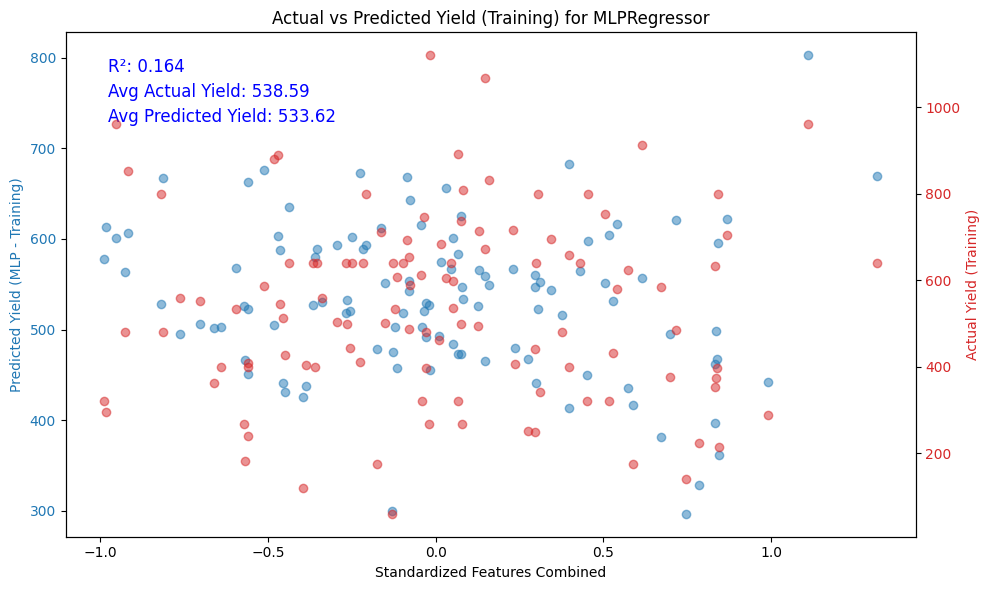

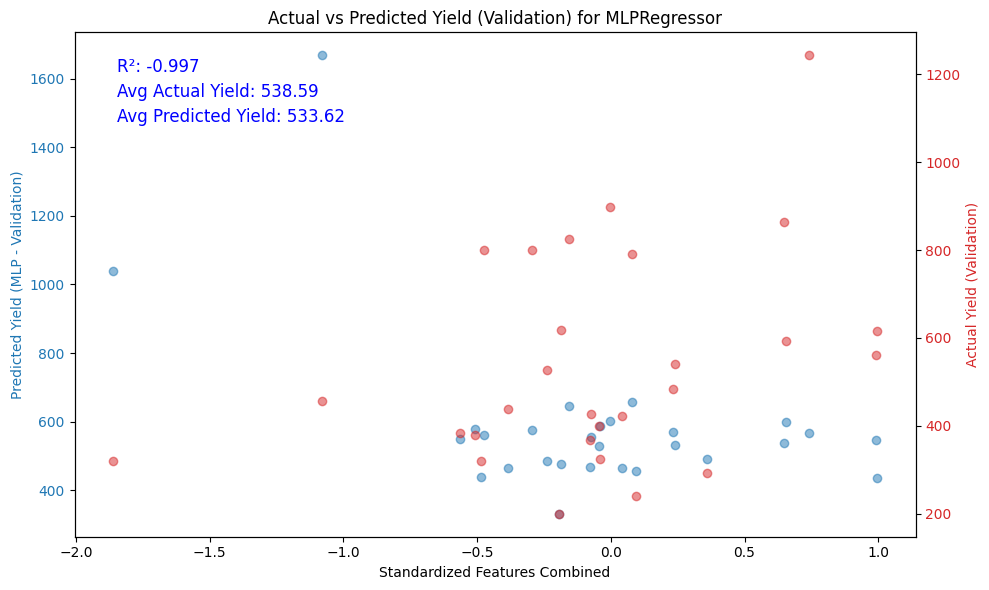

In [82]:
import pandas as pd
import gspread
from google.auth import default
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and connect to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets
def load_data_from_google_sheet(sheet_url):
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# URL for the Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data from the Google Sheets
data = load_data_from_google_sheet(sheet_url)

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Feature Selection based on Random Forest and correlation
correlation_matrix = data[features].corr()
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Feature Importance from Random Forest
X = data[features]
y = data[target]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

# Drop features with high correlation and low importance
threshold = 0.05
low_importance_features = feature_importances[feature_importances['Importance'] < threshold].index
features_reduced = [col for col in features if col not in correlated_features and col not in low_importance_features]

# Print the final features used in the model after feature selection
print(f"Final selected features used in the model: {features_reduced}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_reduced])
y = data[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 1: Hyperparameter Tuning for MLPRegressor (using GridSearchCV)
param_grid_mlp = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],  # Various sizes of hidden layers
    'activation': ['tanh', 'relu'],  # Different activation functions
    'solver': ['adam', 'lbfgs'],  # Solvers to try
    'max_iter': [500, 1000],  # Number of iterations
    'learning_rate_init': [0.001, 0.01],  # Learning rate
    'early_stopping': [True],  # Apply early stopping to prevent overfitting
    'validation_fraction': [0.1],  # Fraction of training data used for early stopping
    'n_iter_no_change': [10]  # How many iterations without improvement before stopping
}

# Use GridSearchCV to find the best parameters for MLP
grid_search_mlp = GridSearchCV(MLPRegressor(random_state=42), param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X_train, y_train)

print(f"Best Hyperparameters for MLPRegressor: {grid_search_mlp.best_params_}")

# Step 2: Retrain with best hyperparameters for MLP
best_mlp = grid_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)

# Step 3: Evaluate the MLP Model
y_train_pred_mlp = best_mlp.predict(X_train)
y_val_pred_mlp = best_mlp.predict(X_val)

# MLP Training Metrics
mse_train_mlp = mean_squared_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
rmse_train_mlp = np.sqrt(mse_train_mlp)
avg_actual_train_mlp = np.mean(y_train)
avg_predicted_train_mlp = np.mean(y_train_pred_mlp)

# MLP Validation Metrics
mse_val_mlp = mean_squared_error(y_val, y_val_pred_mlp)
r2_val_mlp = r2_score(y_val, y_val_pred_mlp)
mae_val_mlp = mean_absolute_error(y_val, y_val_pred_mlp)
rmse_val_mlp = np.sqrt(mse_val_mlp)

# Step 4: Plot Actual vs Predicted Yield for MLP Model (Training and Validation)
X_combined_train = X_train.mean(axis=1)  # Averaging across all features for combined visualization
X_combined_val = X_val.mean(axis=1)  # Averaging across all features for combined visualization

# MLP Plot for Training Data
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Standardized Features Combined')
ax1.set_ylabel('Predicted Yield (MLP - Training)', color='tab:blue')
ax1.scatter(X_combined_train, y_train_pred_mlp, color='tab:blue', label='Predicted Yield (MLP - Training)', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Actual Yield (Training)', color='tab:red')
ax2.scatter(X_combined_train, y_train, color='tab:red', label='Actual Yield (Training)', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add metrics to the plot
ax1.text(0.05, 0.95, f'R²: {r2_train_mlp:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Avg Actual Yield: {avg_actual_train_mlp:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.85, f'Avg Predicted Yield: {avg_predicted_train_mlp:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')

plt.title('Actual vs Predicted Yield (Training) for MLPRegressor')
fig.tight_layout()
plt.show()

# MLP Plot for Validation Data
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Standardized Features Combined')
ax1.set_ylabel('Predicted Yield (MLP - Validation)', color='tab:blue')
ax1.scatter(X_combined_val, y_val_pred_mlp, color='tab:blue', label='Predicted Yield (MLP - Validation)', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Actual Yield (Validation)', color='tab:red')
ax2.scatter(X_combined_val, y_val, color='tab:red', label='Actual Yield (Validation)', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add metrics to the plot
ax1.text(0.05, 0.95, f'R²: {r2_val_mlp:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Avg Actual Yield: {avg_actual_train_mlp:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.85, f'Avg Predicted Yield: {avg_predicted_train_mlp:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')

plt.title('Actual vs Predicted Yield (Validation) for MLPRegressor')
fig.tight_layout()
plt.show()


Final Selected Features for Modeling: ['HeatUnit3', 'NDVI3-Cum', 'PRVI-Cum-quarter3', 'CumulativePPT']
[0]	train-rmse:204.49437	eval-rmse:236.74367
[1]	train-rmse:197.49848	eval-rmse:236.67454
[2]	train-rmse:191.53426	eval-rmse:236.23929
[3]	train-rmse:186.15215	eval-rmse:237.11605
[4]	train-rmse:181.43061	eval-rmse:236.24673
[5]	train-rmse:177.39251	eval-rmse:236.46892
[6]	train-rmse:172.84240	eval-rmse:232.26568
[7]	train-rmse:170.32794	eval-rmse:233.19589
[8]	train-rmse:166.60045	eval-rmse:234.58268
[9]	train-rmse:163.94853	eval-rmse:234.02623
[10]	train-rmse:161.14090	eval-rmse:233.48090
[11]	train-rmse:156.20807	eval-rmse:234.37749
[12]	train-rmse:153.09582	eval-rmse:237.66622
[13]	train-rmse:150.75318	eval-rmse:235.97749
[14]	train-rmse:147.57200	eval-rmse:237.36088
[15]	train-rmse:145.42684	eval-rmse:236.62213
[16]	train-rmse:141.61412	eval-rmse:237.39171
[17]	train-rmse:139.10090	eval-rmse:239.10084
[18]	train-rmse:136.36159	eval-rmse:238.42745
[19]	train-rmse:134.94909	eval-rm

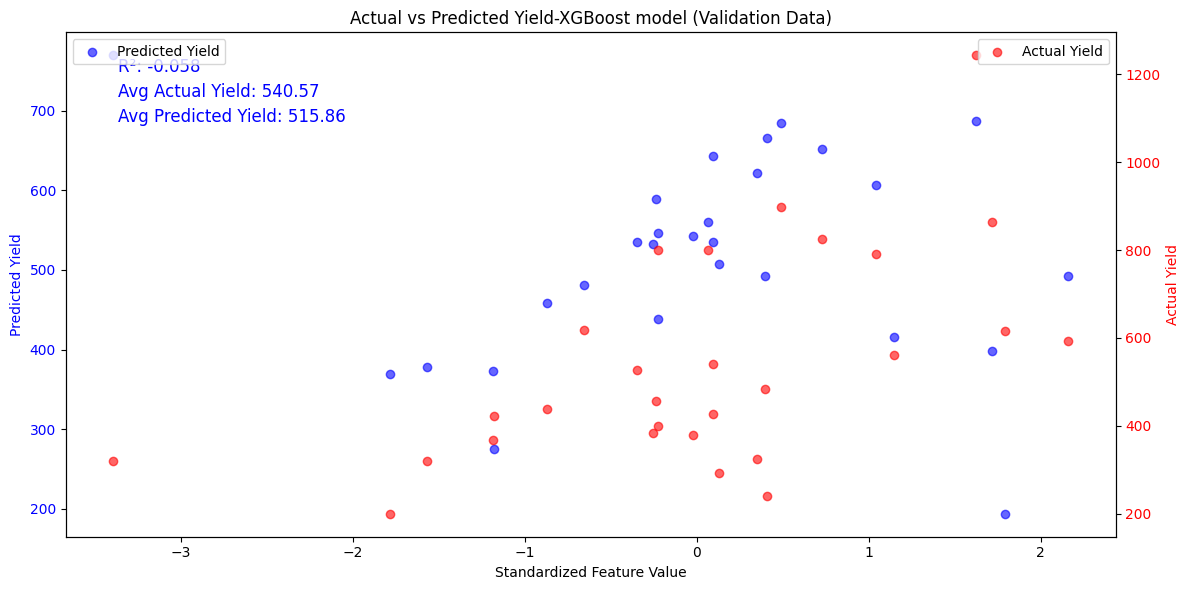


Training Data Evaluation:
R² Score: 0.820260763168335
Mean Squared Error (MSE): 8125.84130859375
Mean Absolute Error (MAE): 69.48323822021484
Root Mean Squared Error (RMSE): 90.14344850622118
Average Actual Yield (Training): 538.5945945945946
Average Predicted Yield (Training): 538.598876953125


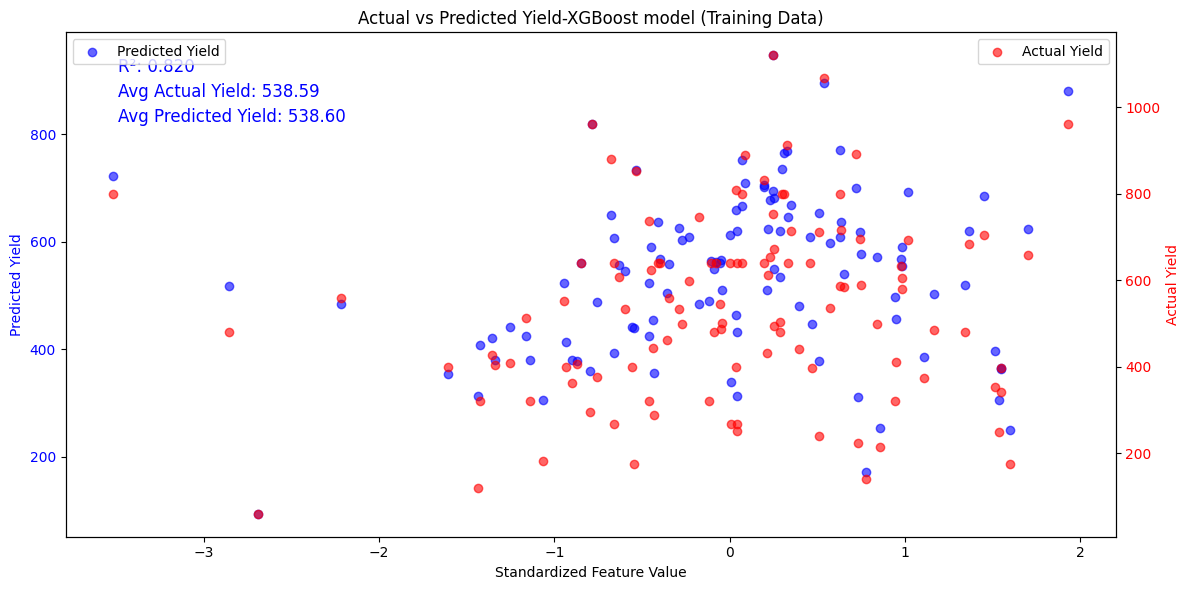

In [84]:
import pandas as pd
import gspread
from google.auth import default
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and connect to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets
def load_data_from_google_sheet(sheet_url):
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# URL for the Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data from the Google Sheets
data = load_data_from_google_sheet(sheet_url)

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Feature Selection based on correlation and importance
correlation_matrix = data[features].corr()
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Feature Importance from XGBoost
X = data[features]
y = data[target]
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                   index=X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

# Drop features with high correlation and low importance
threshold = 0.05
low_importance_features = feature_importances[feature_importances['Importance'] < threshold].index
features_reduced = [col for col in features if col not in correlated_features and col not in low_importance_features]

# Print final selected features for modeling
print(f"Final Selected Features for Modeling: {features_reduced}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_reduced])
y = data[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the XGBoost model with regularization parameters
params = {
    'max_depth': 3,  # Lower tree depth to reduce complexity
    'learning_rate': 0.1,
    'gamma': 0.1,  # Regularization term
    'reg_alpha': 0.01,  # L1 regularization term
    'reg_lambda': 0.01,  # L2 regularization term
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eval_metric': 'rmse',  # Pass eval_metric here
    'random_state': 42
}

# Prepare the DMatrix for XGBoost (instead of directly passing NumPy arrays)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# List of evaluation datasets (training and validation sets)
evals = [(dtrain, 'train'), (dval, 'eval')]

# Train the model with early stopping using xgb.train
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Higher number of estimators
    evals=evals,
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds
    verbose_eval=True  # To display progress during training
)

# Predict on validation data
y_val_pred = model.predict(dval)

# Evaluate the model on validation data
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)

# Calculate average actual and predicted yields for validation data
avg_actual_yield_val = y_val.mean()
avg_predicted_yield_val = y_val_pred.mean()

# Print evaluation metrics for validation
print(f"\nValidation Data Evaluation:")
print(f"R² Score: {r2_val}")
print(f"Mean Squared Error (MSE): {mse_val}")
print(f"Mean Absolute Error (MAE): {mae_val}")
print(f"Root Mean Squared Error (RMSE): {rmse_val}")
print(f"Average Actual Yield (Validation): {avg_actual_yield_val}")
print(f"Average Predicted Yield (Validation): {avg_predicted_yield_val}")

# Create a plot for the validation data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the standardized feature values on the x-axis
x_values_val = X_val[:, 0]  # Use the first feature as an example
ax1.scatter(x_values_val, y_val_pred, color='blue', label='Predicted Yield', alpha=0.6)
ax1.set_xlabel('Standardized Feature Value')
ax1.set_ylabel('Predicted Yield', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis for the actual yield
ax2 = ax1.twinx()
ax2.scatter(x_values_val, y_val, color='red', label='Actual Yield', alpha=0.6)
ax2.set_ylabel('Actual Yield', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add metrics to the plot
ax1.text(0.05, 0.95, f'R²: {r2_val:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Avg Actual Yield: {avg_actual_yield_val:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.85, f'Avg Predicted Yield: {avg_predicted_yield_val:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')

# Title and Legends
ax1.set_title('Actual vs Predicted Yield-XGBoost model (Validation Data)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# Predict on training data
y_train_pred = model.predict(dtrain)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculate average actual and predicted yields for training data
avg_actual_yield_train = y_train.mean()
avg_predicted_yield_train = y_train_pred.mean()

# Print evaluation metrics for training
print(f"\nTraining Data Evaluation:")
print(f"R² Score: {r2_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"Average Actual Yield (Training): {avg_actual_yield_train}")
print(f"Average Predicted Yield (Training): {avg_predicted_yield_train}")

# Create a plot for the training data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the standardized feature values on the x-axis
x_values_train = X_train[:, 0]  # Use the first feature as an example
ax1.scatter(x_values_train, y_train_pred, color='blue', label='Predicted Yield', alpha=0.6)
ax1.set_xlabel('Standardized Feature Value')
ax1.set_ylabel('Predicted Yield', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis for the actual yield
ax2 = ax1.twinx()
ax2.scatter(x_values_train, y_train, color='red', label='Actual Yield', alpha=0.6)
ax2.set_ylabel('Actual Yield', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add metrics to the plot
ax1.text(0.05, 0.95, f'R²: {r2_train:.3f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Avg Actual Yield: {avg_actual_yield_train:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')
ax1.text(0.05, 0.85, f'Avg Predicted Yield: {avg_predicted_yield_train:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='blue')

# Title and Legends
ax1.set_title('Actual vs Predicted Yield-XGBoost model (Training Data)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


Final Selected Features for Modeling: ['HeatUnit3', 'NDVI3-Cum', 'PRVI-Cum-quarter3', 'CumulativePPT']
Best Alpha from LassoCV: 0.037401072991045496

Validation Data Evaluation:
R² Score: -0.1797565127746008
Mean Squared Error (MSE): 66496.84342089096
Mean Absolute Error (MAE): 196.68956205980842
Root Mean Squared Error (RMSE): 257.86981874754355
Average Actual Yield (Validation): 540.5714285714286
Average Predicted Yield (Validation): 550.6925620278696


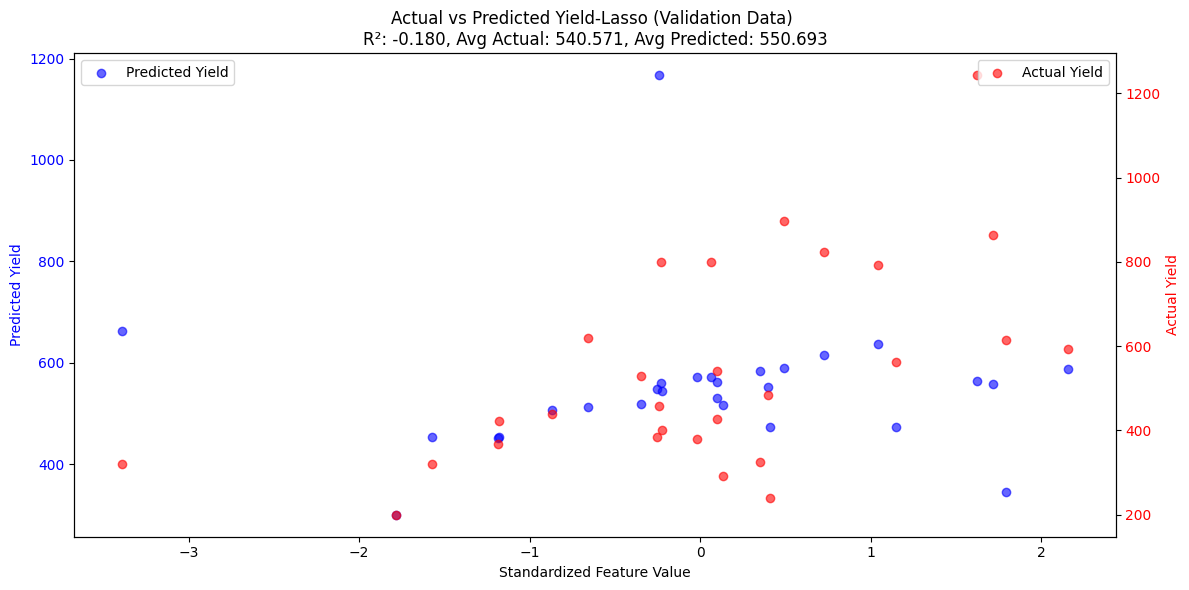


Training Data Evaluation:
R² Score: 0.1318372222633014
Mean Squared Error (MSE): 39248.816043941086
Mean Absolute Error (MAE): 158.1002662134144
Root Mean Squared Error (RMSE): 198.11313950351976
Average Actual Yield (Training): 538.5945945945946
Average Predicted Yield (Training): 538.5945945945946


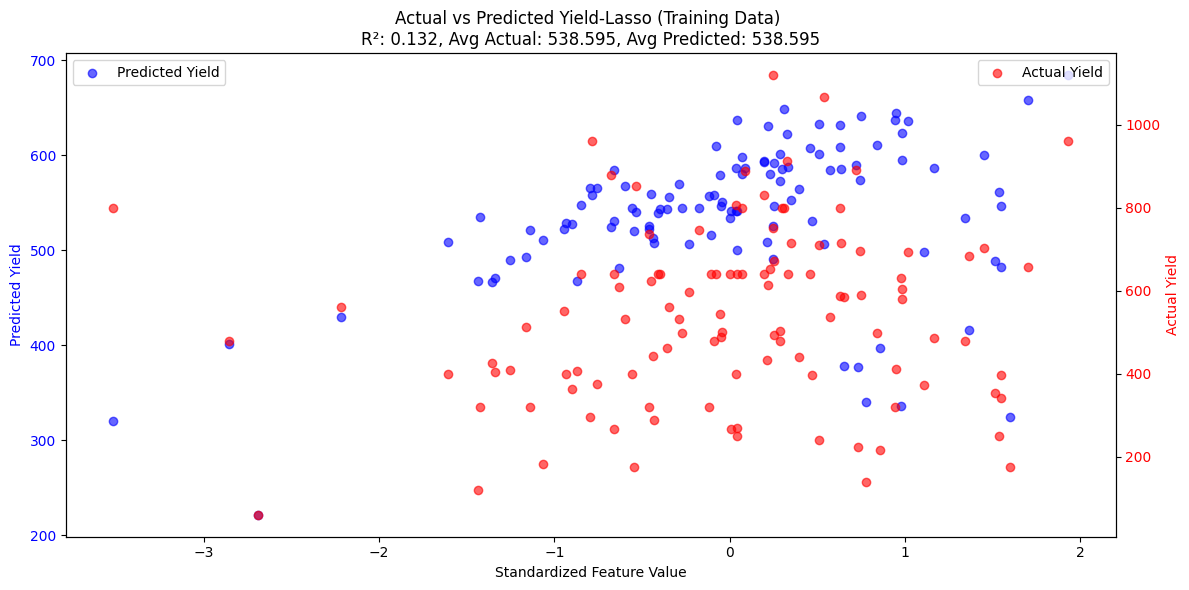

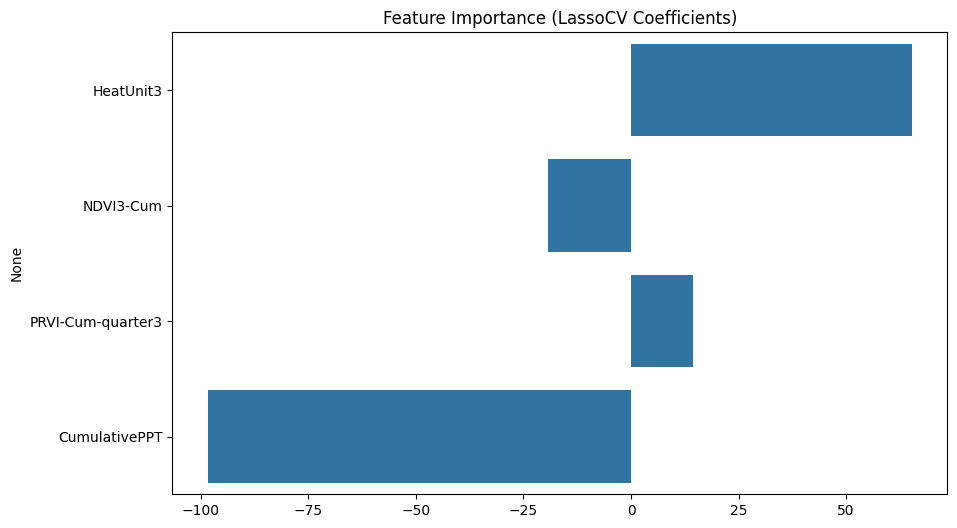


Cross-Validation R² Scores: [ 0.03350651 -0.15132304  0.14200488  0.02348087 -0.03827109]
Mean Cross-Validation R² Score: 0.0018796236600257421


In [85]:
import pandas as pd
import gspread
from google.auth import default
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV  # Use LassoCV for automatic alpha tuning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Authenticate and connect to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets
def load_data_from_google_sheet(sheet_url):
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# URL for the Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data from the Google Sheets
data = load_data_from_google_sheet(sheet_url)

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Feature Selection based on correlation and importance
correlation_matrix = data[features].corr()
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Feature Importance using the correlation matrix and feature selection
X = data[features]
y = data[target]

# Drop features with high correlation
features_reduced = [col for col in features if col not in correlated_features]

# Print final selected features for modeling
print(f"Final Selected Features for Modeling: {features_reduced}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_reduced])
y = data[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the LassoCV model with automatic alpha tuning using cross-validation
lasso_cv = LassoCV(cv=5, random_state=42)

# Train the model
lasso_cv.fit(X_train, y_train)

# Best alpha parameter found by LassoCV
print(f"Best Alpha from LassoCV: {lasso_cv.alpha_}")

# Predict on validation data
y_val_pred = lasso_cv.predict(X_val)

# Evaluate the model on validation data
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)

# Calculate average actual and predicted yields for validation data
avg_actual_yield_val = y_val.mean()
avg_predicted_yield_val = y_val_pred.mean()

# Print evaluation metrics for validation
print(f"\nValidation Data Evaluation:")
print(f"R² Score: {r2_val}")
print(f"Mean Squared Error (MSE): {mse_val}")
print(f"Mean Absolute Error (MAE): {mae_val}")
print(f"Root Mean Squared Error (RMSE): {rmse_val}")
print(f"Average Actual Yield (Validation): {avg_actual_yield_val}")
print(f"Average Predicted Yield (Validation): {avg_predicted_yield_val}")

# Create a plot for the validation data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the standardized feature values on the x-axis
x_values_val = X_val[:, 0]  # Use the first feature as an example
ax1.scatter(x_values_val, y_val_pred, color='blue', label='Predicted Yield', alpha=0.6)
ax1.set_xlabel('Standardized Feature Value')
ax1.set_ylabel('Predicted Yield', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis for the actual yield
ax2 = ax1.twinx()
ax2.scatter(x_values_val, y_val, color='red', label='Actual Yield', alpha=0.6)
ax2.set_ylabel('Actual Yield', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and Legends
ax1.set_title(f'Actual vs Predicted Yield-Lasso (Validation Data) \nR²: {r2_val:.3f}, Avg Actual: {avg_actual_yield_val:.3f}, Avg Predicted: {avg_predicted_yield_val:.3f}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# Predict on training data
y_train_pred = lasso_cv.predict(X_train)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculate average actual and predicted yields for training data
avg_actual_yield_train = y_train.mean()
avg_predicted_yield_train = y_train_pred.mean()

# Print evaluation metrics for training
print(f"\nTraining Data Evaluation:")
print(f"R² Score: {r2_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"Average Actual Yield (Training): {avg_actual_yield_train}")
print(f"Average Predicted Yield (Training): {avg_predicted_yield_train}")

# Create a plot for the training data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the standardized feature values on the x-axis
x_values_train = X_train[:, 0]  # Use the first feature as an example
ax1.scatter(x_values_train, y_train_pred, color='blue', label='Predicted Yield', alpha=0.6)
ax1.set_xlabel('Standardized Feature Value')
ax1.set_ylabel('Predicted Yield', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis for the actual yield
ax2 = ax1.twinx()
ax2.scatter(x_values_train, y_train, color='red', label='Actual Yield', alpha=0.6)
ax2.set_ylabel('Actual Yield', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and Legends
ax1.set_title(f'Actual vs Predicted Yield-Lasso (Training Data) \nR²: {r2_train:.3f}, Avg Actual: {avg_actual_yield_train:.3f}, Avg Predicted: {avg_predicted_yield_train:.3f}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# Feature Importance: Visualize the coefficients of the model
coefficients = pd.Series(lasso_cv.coef_, index=features_reduced)
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.values, y=coefficients.index)
plt.title("Feature Importance (LassoCV Coefficients)")
plt.show()

# Cross-validation scores to evaluate model performance
cv_scores = cross_val_score(lasso_cv, X_scaled, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {cv_scores.mean()}")


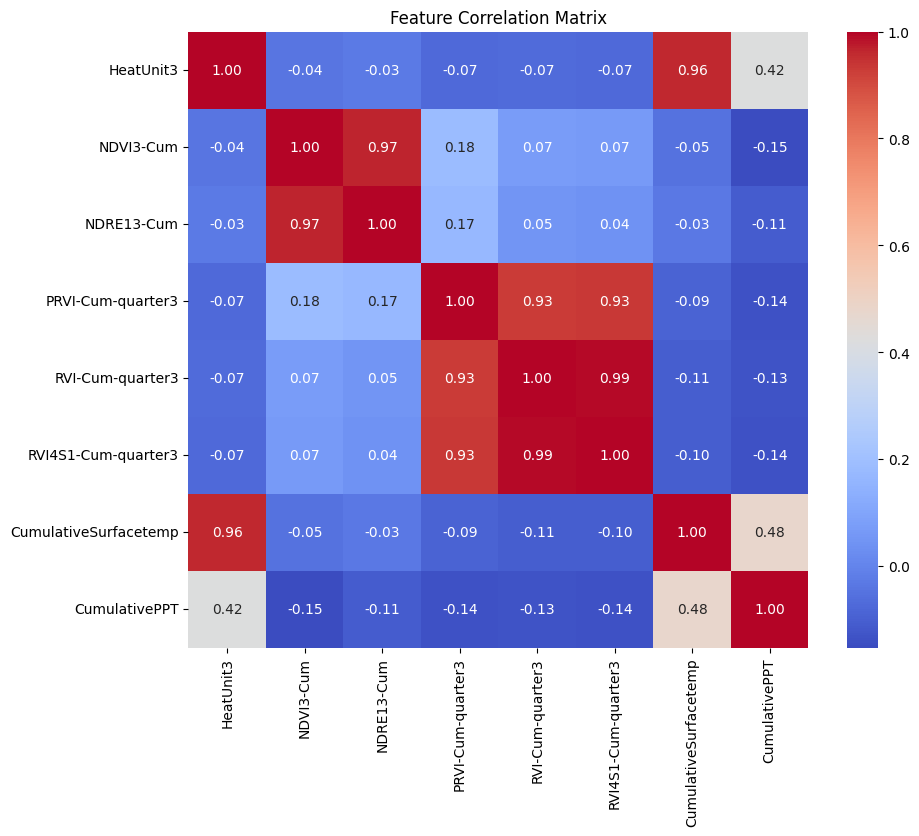

Highly correlated features (correlation > 0.9): {'RVI4S1-Cum-quarter3', 'RVI-Cum-quarter3', 'CumulativeSurfacetemp', 'NDRE13-Cum'}
Feature Importance from Random Forest:
                       Importance
CumulativePPT            0.244447
HeatUnit3                0.225863
NDRE13-Cum               0.125357
PRVI-Cum-quarter3        0.108710
NDVI3-Cum                0.081655
CumulativeSurfacetemp    0.078765
RVI-Cum-quarter3         0.072955
RVI4S1-Cum-quarter3      0.062250
Low importance features to drop: Index([], dtype='object')
Reduced feature set: ['HeatUnit3', 'NDVI3-Cum', 'PRVI-Cum-quarter3', 'CumulativePPT']
Random Forest - MSE: 50444.72501071428, R²: 0.10503281351521654
XGBoost - MSE: 71921.0, R²: -0.2759895324707031
Lasso - MSE: 66468.45482363147, R²: -0.17925285529580215


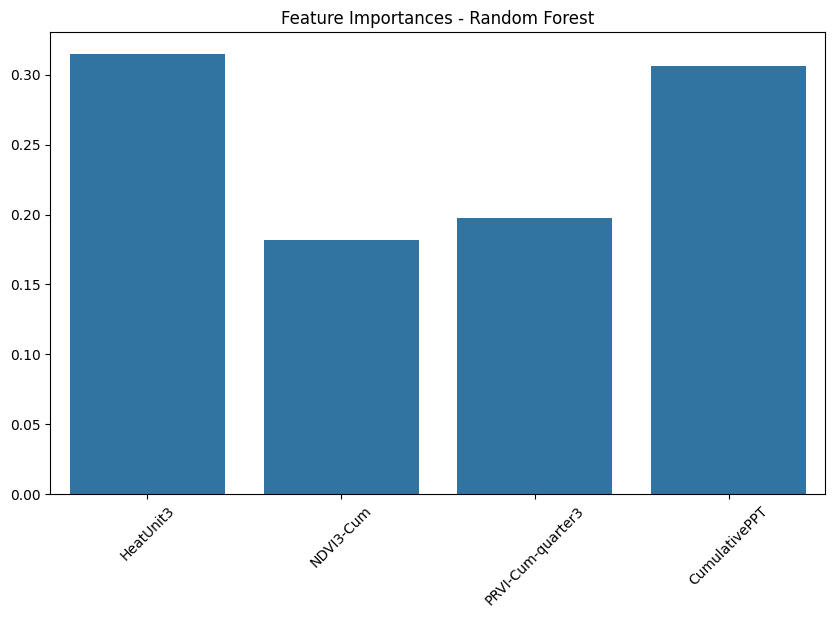

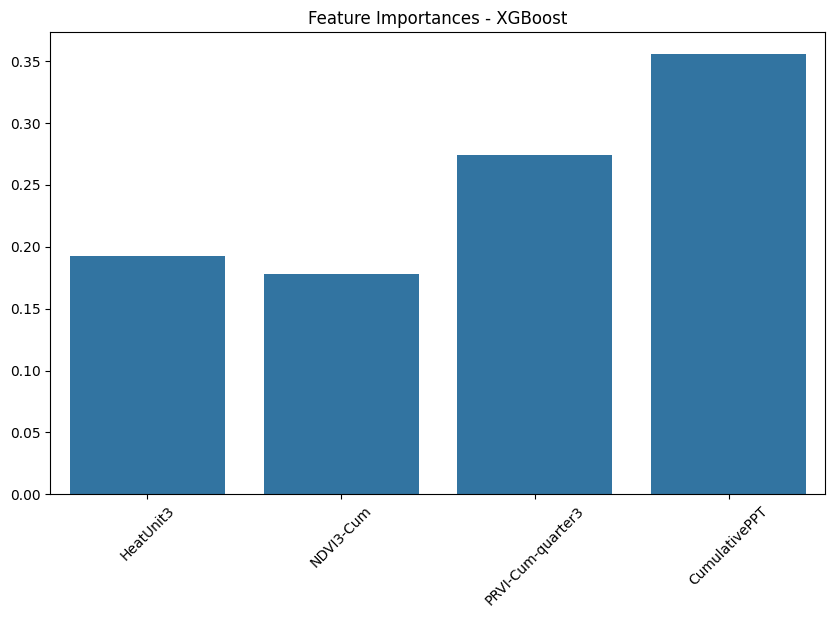

Random Forest - MSE: 50444.72501071428, R²: 0.10503281351521654
XGBoost - MSE: 71921.0, R²: -0.2759895324707031
Lasso - MSE: 66468.45482363147, R²: -0.17925285529580215


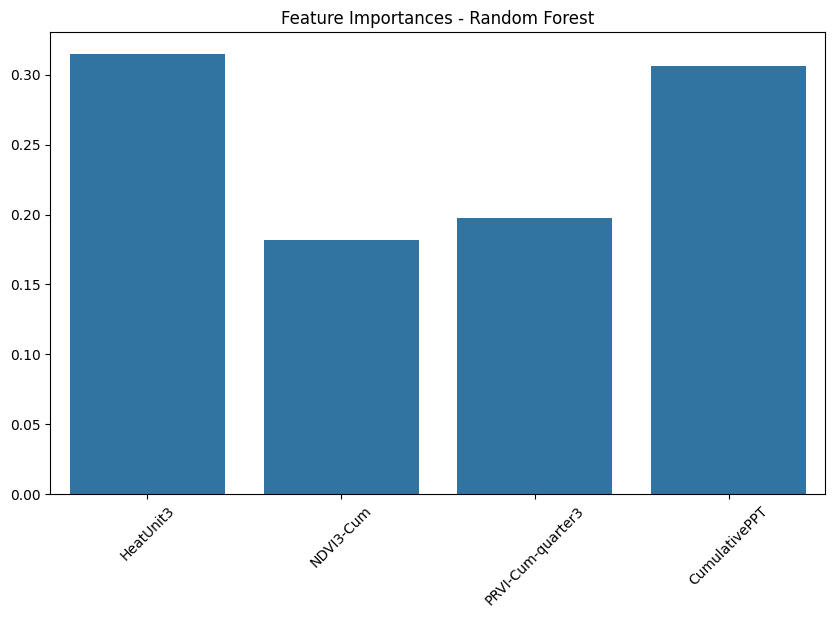

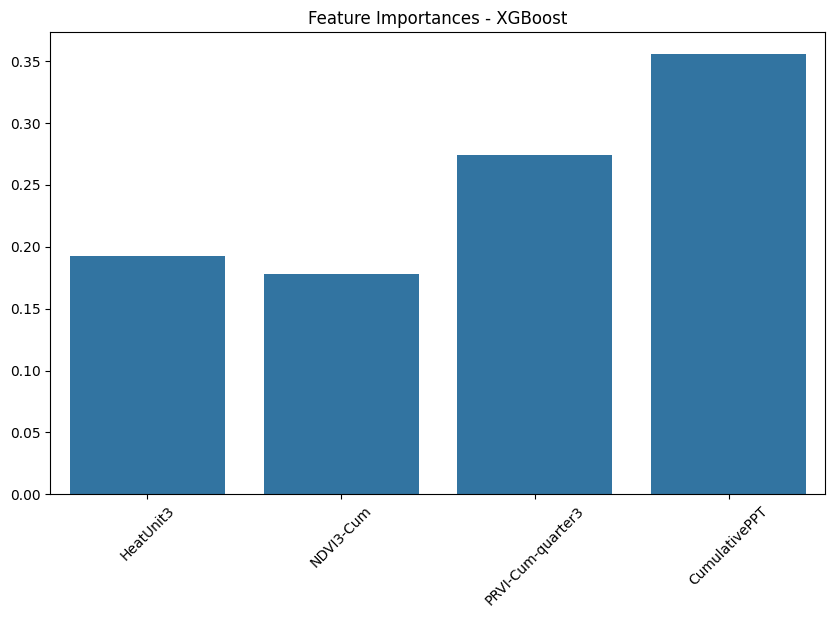

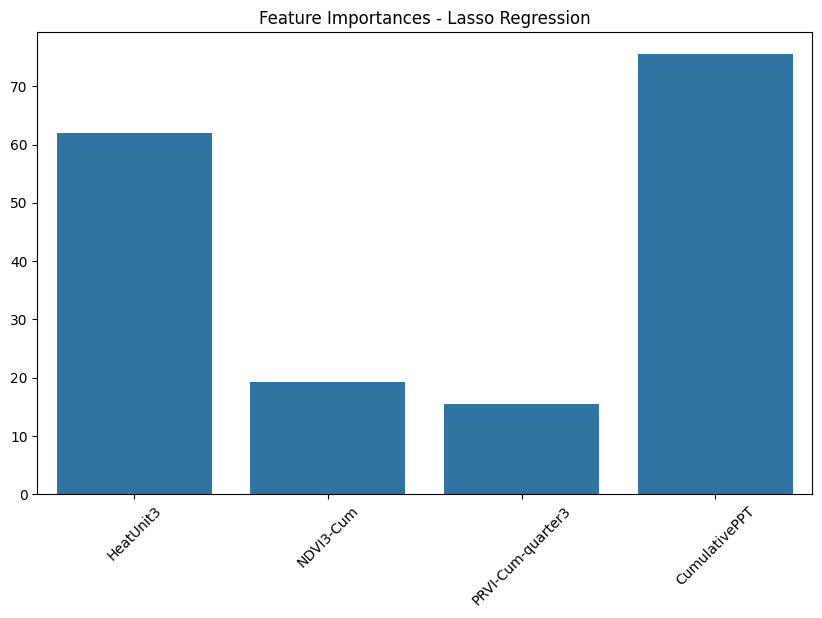

In [86]:
import pandas as pd
import gspread
from google.auth import default
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Authenticate and connect to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets
def load_data_from_google_sheet(sheet_url):
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# URL for the Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data from Google Sheets
data = load_data_from_google_sheet(sheet_url)

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Step 1: Correlation Analysis
# Calculate the correlation matrix
correlation_matrix = data[features].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify features with high correlation (greater than 0.9)
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Highly correlated features (correlation > 0.9): {correlated_features}")

# Step 2: Feature Importance using Random Forest
# Train Random Forest model to check feature importance
X = data[features]
y = data[target]

# Split data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("Feature Importance from Random Forest:")
print(feature_importances)

# Drop features with low importance (you can decide a threshold, e.g., remove features with importance < 0.05)
threshold = 0.05
low_importance_features = feature_importances[feature_importances['Importance'] < threshold].index
print(f"Low importance features to drop: {low_importance_features}")

# Step 3: Train Model with Reduced Features
# Dropping correlated and low importance features
features_reduced = [col for col in features if col not in correlated_features and col not in low_importance_features]

# Print the new feature set
print(f"Reduced feature set: {features_reduced}")

# Split data into training (80%) and validation (20%) sets
X_reduced = data[features_reduced]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features_reduced])
X_val_scaled = scaler.transform(X_val[features_reduced])

# Step 4: Model Comparisons (Random Forest, XGBoost, Lasso)

# 1. **Random Forest**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)

# 2. **XGBoost (Without GridSearchCV)**
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)

# 3. **Lasso Regression**
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_val_scaled)

# Evaluate all models
models = {
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Lasso': lasso_pred
}

for model_name, pred in models.items():
    mse = mean_squared_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    print(f"{model_name} - MSE: {mse}, R²: {r2}")

# Step 5: Visualizing Feature Importance

# Plot feature importance from Random Forest
rf_importances = rf_model.feature_importances_
feature_names = features_reduced
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=rf_importances)
plt.title("Feature Importances - Random Forest")
plt.xticks(rotation=45)
plt.show()

# Plot feature importance from XGBoost
xgb_importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=xgb_importances)
plt.title("Feature Importances - XGBoost")
plt.xticks(rotation=45)
plt.show()


# Evaluate and visualize feature importance for Random Forest, XGBoost, and Lasso

# 1. **Random Forest**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)

# 2. **XGBoost (Without GridSearchCV)**
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)

# 3. **Lasso Regression**
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_val_scaled)

# Evaluate all models
models = {
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Lasso': lasso_pred
}

for model_name, pred in models.items():
    mse = mean_squared_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    print(f"{model_name} - MSE: {mse}, R²: {r2}")

# Step 5: Visualizing Feature Importance

# Plot feature importance from Random Forest
rf_importances = rf_model.feature_importances_
feature_names = features_reduced
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=rf_importances)
plt.title("Feature Importances - Random Forest")
plt.xticks(rotation=45)
plt.show()

# Plot feature importance from XGBoost
xgb_importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=xgb_importances)
plt.title("Feature Importances - XGBoost")
plt.xticks(rotation=45)
plt.show()

# 4. **Lasso Feature Importance (based on the magnitude of the coefficients)**
lasso_importances = abs(lasso_model.coef_)  # Taking the absolute value of coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=lasso_importances)
plt.title("Feature Importances - Lasso Regression")
plt.xticks(rotation=45)
plt.show()


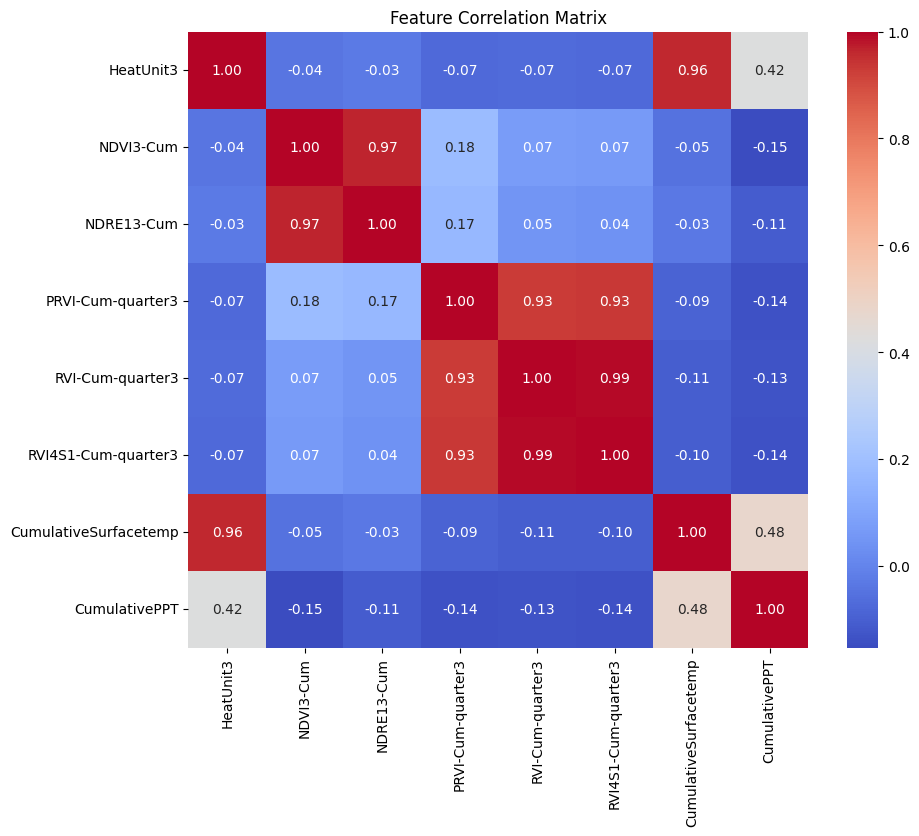

Highly correlated features (correlation > 0.9): {'RVI4S1-Cum-quarter3', 'RVI-Cum-quarter3', 'CumulativeSurfacetemp', 'NDRE13-Cum'}


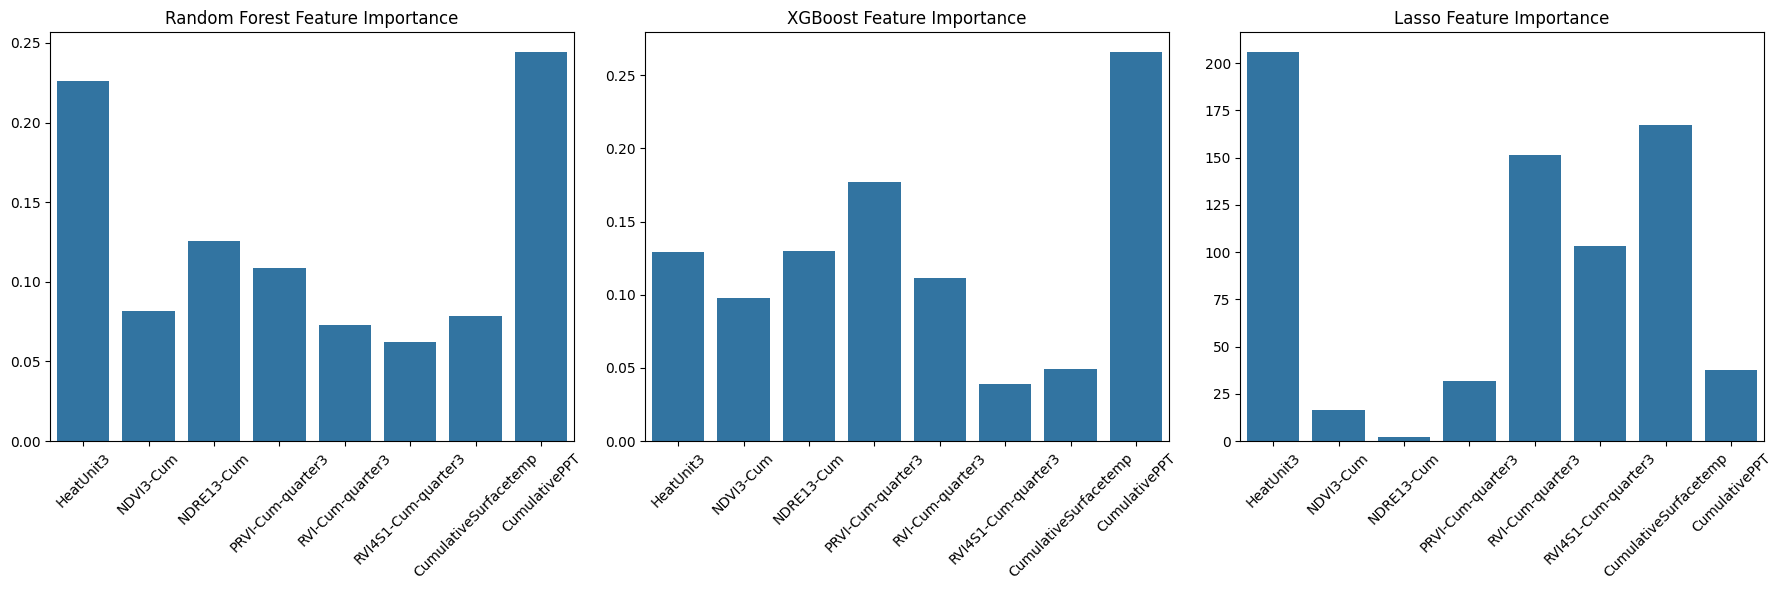

Selected features (Random Forest): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']
Selected features (XGBoost): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'CumulativePPT']
Selected features (Lasso): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']
Random Forest - MSE: 47062.43585714285, R²: 0.16503983718333826
XGBoost - MSE: 68194.171875, R²: -0.2098698616027832
Lasso - MSE: 60298.83780747537, R²: -0.06979433844463312
Best Model: Random Forest


In [87]:
import pandas as pd
import gspread
from google.auth import default
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# Authenticate and connect to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets
def load_data_from_google_sheet(sheet_url):
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# URL for the Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data from Google Sheets
data = load_data_from_google_sheet(sheet_url)

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Step 1: Correlation Analysis
# Calculate the correlation matrix
correlation_matrix = data[features].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify features with high correlation (greater than 0.9)
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Highly correlated features (correlation > 0.9): {correlated_features}")

# Step 2: Feature Importance using Random Forest, XGBoost, and Lasso
# Train Random Forest model to check feature importance
X = data[features]
y = data[target]

# Split data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 1. **Random Forest**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_importances = rf_model.feature_importances_

# 2. **XGBoost**
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_importances = xgb_model.feature_importances_

# 3. **Lasso**
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_importances = abs(lasso_model.coef_)  # Absolute values of coefficients are used as importance

# Visualize feature importance from all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest Feature Importance
sns.barplot(x=features, y=rf_importances, ax=axes[0])
axes[0].set_title("Random Forest Feature Importance")
axes[0].tick_params(axis='x', rotation=45)

# XGBoost Feature Importance
sns.barplot(x=features, y=xgb_importances, ax=axes[1])
axes[1].set_title("XGBoost Feature Importance")
axes[1].tick_params(axis='x', rotation=45)

# Lasso Feature Importance
sns.barplot(x=features, y=lasso_importances, ax=axes[2])
axes[2].set_title("Lasso Feature Importance")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Step 3: Feature Selection Based on Importance

# Set a threshold for importance to select top features for each model
threshold = 0.05
rf_selected_features = [features[i] for i in range(len(features)) if rf_importances[i] > threshold]
xgb_selected_features = [features[i] for i in range(len(features)) if xgb_importances[i] > threshold]
lasso_selected_features = [features[i] for i in range(len(features)) if lasso_importances[i] > threshold]

print(f"Selected features (Random Forest): {rf_selected_features}")
print(f"Selected features (XGBoost): {xgb_selected_features}")
print(f"Selected features (Lasso): {lasso_selected_features}")

# Step 4: Model Comparison with Selected Features

# Create function to train and evaluate models
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mse, r2

# Compare models using selected features from Random Forest, XGBoost, and Lasso

# 1. Random Forest using selected features
X_train_rf = X_train[rf_selected_features]
X_val_rf = X_val[rf_selected_features]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mse, rf_r2 = train_and_evaluate_model(rf_model, X_train_rf, X_val_rf, y_train, y_val)

# 2. XGBoost using selected features
X_train_xgb = X_train[xgb_selected_features]
X_val_xgb = X_val[xgb_selected_features]
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_mse, xgb_r2 = train_and_evaluate_model(xgb_model, X_train_xgb, X_val_xgb, y_train, y_val)

# 3. Lasso using selected features
X_train_lasso = X_train[lasso_selected_features]
X_val_lasso = X_val[lasso_selected_features]
lasso_model = Lasso(alpha=0.1)
lasso_mse, lasso_r2 = train_and_evaluate_model(lasso_model, X_train_lasso, X_val_lasso, y_train, y_val)

# Print Model Performance
print(f"Random Forest - MSE: {rf_mse}, R²: {rf_r2}")
print(f"XGBoost - MSE: {xgb_mse}, R²: {xgb_r2}")
print(f"Lasso - MSE: {lasso_mse}, R²: {lasso_r2}")

# Step 5: Final Model Evaluation (Choose the best model based on MSE and R²)
best_model = "Random Forest" if rf_r2 > xgb_r2 and rf_r2 > lasso_r2 else "XGBoost" if xgb_r2 > lasso_r2 else "Lasso"
print(f"Best Model: {best_model}")


                    FarmerName Yield CumulativeSurfacetemp CumulativePPT  \
0      Ajaybhai Manubhai Patel   493           4548.839087   693.2014011   
1   Ajaysinh Himmatsinh Rathod   223           5067.879502   824.8145109   
2  Ajitbhai Narsangbhai Parmar    60           3376.276386   773.3113444   
3     Ajitsinh Mansinh Chavada   342            5348.39497   750.6391979   
4     Ajitsinh Rajusinh Bihola   379           4547.263849   682.0123438   

   HeatUnit3 NDVI3-Cum NDRE13-Cum PRVI-Cum-quarter3 RVI-Cum-quarter3  \
0   2124.527      10.4   5.723333          0.071075         11.25836   
1  2214.8719       9.7   5.365001          0.085163         13.36613   
2  1566.6984      10.8   6.190061          0.081047         9.914198   
3  2369.6227         9   4.652742          0.052694         9.090344   
4  2072.4521       7.9   3.989126          0.058029         9.806239   

  RVI4S1-Cum-quarter3  
0            4.931249  
1            6.250817  
2             4.09784  
3            3

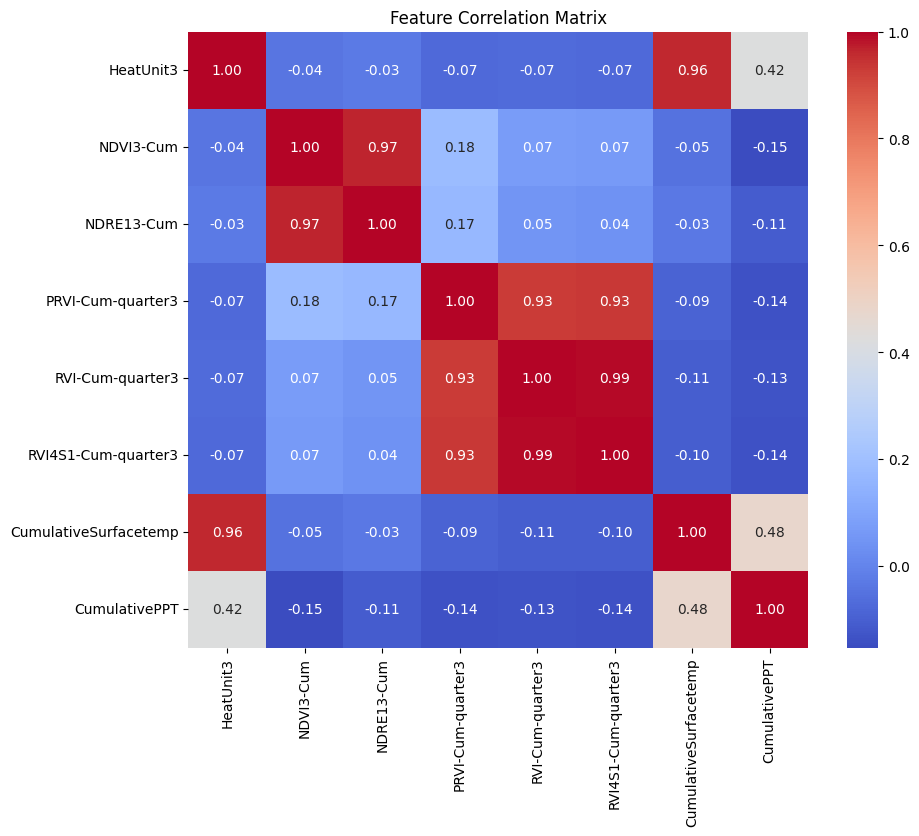

Highly correlated features (correlation > 0.9): {'RVI4S1-Cum-quarter3', 'RVI-Cum-quarter3', 'CumulativeSurfacetemp', 'NDRE13-Cum'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


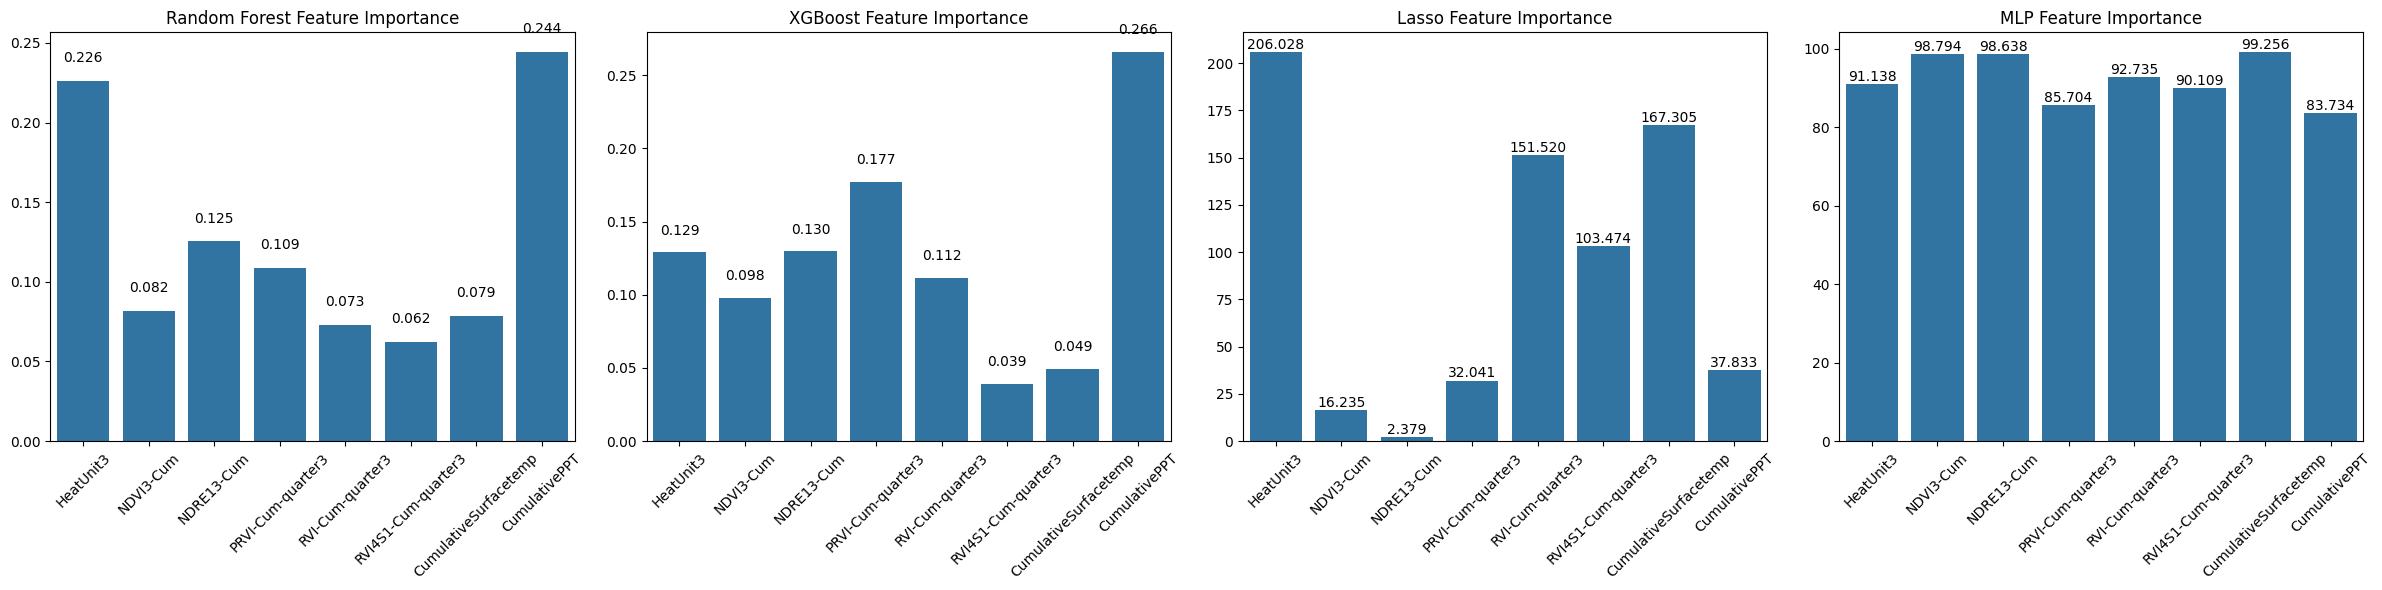

Selected features (Random Forest): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']
Selected features (XGBoost): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'CumulativePPT']
Selected features (Lasso): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']
Selected features (MLP): ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3', 'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']
Random Forest - MSE: 47062.43585714285, R²: 0.16503983718333826
XGBoost - MSE: 68194.171875, R²: -0.2098698616027832
Lasso - MSE: 60298.83780747537, R²: -0.06979433844463312
MLP - MSE: 61170.89497567078, R²: -0.08526597695803484
Best Model: Random Forest


In [88]:
# Step 1: Install necessary libraries
!pip install --upgrade gspread google-auth

# Step 2: Authenticate with Google using google-auth
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Authenticate the Google account
auth.authenticate_user()

# Use google-auth to get credentials and authorize gspread
creds, _ = default()
gc = gspread.authorize(creds)

# Function to load data from Google Sheets and convert it to DataFrame
def load_data_from_google_sheet(sheet_url):
    # Open the Google Sheet using its URL
    sheet = gc.open_by_url(sheet_url)
    worksheet = sheet.sheet1  # You can change to a specific sheet by name if needed
    # Get all data from the sheet
    data = worksheet.get_all_values()
    # Convert to DataFrame using pandas
    df = pd.DataFrame(data[1:], columns=data[0])  # Exclude header row and set as columns
    return df

# URL of your Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1Bs3ggdeODE0xIBmrjhCVhNGSuyh3iCsP8Y93d89PKrY/edit?gid=321127261#gid=321127261'

# Load the data into a DataFrame
data = load_data_from_google_sheet(sheet_url)

# Show the first few rows of the DataFrame to check
print(data.head())

# Feature columns based on your description
features = ['HeatUnit3', 'NDVI3-Cum', 'NDRE13-Cum', 'PRVI-Cum-quarter3',
            'RVI-Cum-quarter3', 'RVI4S1-Cum-quarter3', 'CumulativeSurfacetemp', 'CumulativePPT']

# Dependent variable column
target = 'Yield'

# Convert relevant columns to numeric values (if they are not already)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values in any of the columns
data.dropna(subset=features + [target], inplace=True)

# Step 1: Correlation Analysis
# Calculate the correlation matrix
correlation_matrix = data[features].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify features with high correlation (greater than 0.9)
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Highly correlated features (correlation > 0.9): {correlated_features}")

# Step 2: Feature Importance using Random Forest, XGBoost, Lasso, and MLP
# Train Random Forest model to check feature importance
X = data[features]
y = data[target]

# Split data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 1. **Random Forest**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_importances = rf_model.feature_importances_

# 2. **XGBoost**
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_importances = xgb_model.feature_importances_

# 3. **Lasso**
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_importances = abs(lasso_model.coef_)  # Absolute values of coefficients are used as importance

import numpy as np  # Make sure numpy is imported

# 4. **MLP (Multilayer Perceptron)**
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Extract weights of the first layer (input to hidden layer)
first_layer_weights = mlp_model.coefs_[0]  # Weights between input and first hidden layer

# Calculate the feature importance by summing the absolute values of weights for each feature across all hidden neurons
mlp_importances = np.abs(first_layer_weights).sum(axis=1)  # Use np.abs() instead of .abs()

# Ensure that the length of mlp_importances matches the length of features
assert len(mlp_importances) == len(features), f"Length mismatch between features ({len(features)}) and MLP importances ({len(mlp_importances)})"

# Visualize feature importance from all four models with annotations of importance values
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Random Forest Feature Importance
sns.barplot(x=features, y=rf_importances, ax=axes[0])
axes[0].set_title("Random Forest Feature Importance")
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(rf_importances):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

# XGBoost Feature Importance
sns.barplot(x=features, y=xgb_importances, ax=axes[1])
axes[1].set_title("XGBoost Feature Importance")
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(xgb_importances):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

# Lasso Feature Importance
sns.barplot(x=features, y=lasso_importances, ax=axes[2])
axes[2].set_title("Lasso Feature Importance")
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(lasso_importances):
    axes[2].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

# MLP Feature Importance
sns.barplot(x=features, y=mlp_importances, ax=axes[3])
axes[3].set_title("MLP Feature Importance")
axes[3].tick_params(axis='x', rotation=45)
for i, v in enumerate(mlp_importances):
    axes[3].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Step 3: Feature Selection Based on Importance

# Set a threshold for importance to select top features for each model
threshold = 0.05
rf_selected_features = [features[i] for i in range(len(features)) if rf_importances[i] > threshold]
xgb_selected_features = [features[i] for i in range(len(features)) if xgb_importances[i] > threshold]
lasso_selected_features = [features[i] for i in range(len(features)) if lasso_importances[i] > threshold]
mlp_selected_features = [features[i] for i in range(len(features)) if mlp_importances[i] > threshold]

print(f"Selected features (Random Forest): {rf_selected_features}")
print(f"Selected features (XGBoost): {xgb_selected_features}")
print(f"Selected features (Lasso): {lasso_selected_features}")
print(f"Selected features (MLP): {mlp_selected_features}")

# Step 4: Model Comparison with Selected Features

# Create function to train and evaluate models
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mse, r2

# Compare models using selected features from Random Forest, XGBoost, Lasso, and MLP

# 1. Random Forest using selected features
X_train_rf = X_train[rf_selected_features]
X_val_rf = X_val[rf_selected_features]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mse, rf_r2 = train_and_evaluate_model(rf_model, X_train_rf, X_val_rf, y_train, y_val)

# 2. XGBoost using selected features
X_train_xgb = X_train[xgb_selected_features]
X_val_xgb = X_val[xgb_selected_features]
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_mse, xgb_r2 = train_and_evaluate_model(xgb_model, X_train_xgb, X_val_xgb, y_train, y_val)

# 3. Lasso using selected features
X_train_lasso = X_train[lasso_selected_features]
X_val_lasso = X_val[lasso_selected_features]
lasso_model = Lasso(alpha=0.1)
lasso_mse, lasso_r2 = train_and_evaluate_model(lasso_model, X_train_lasso, X_val_lasso, y_train, y_val)

# 4. MLP using selected features
X_train_mlp = X_train[mlp_selected_features]
X_val_mlp = X_val[mlp_selected_features]
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_mse, mlp_r2 = train_and_evaluate_model(mlp_model, X_train_mlp, X_val_mlp, y_train, y_val)

# Print Model Performance
print(f"Random Forest - MSE: {rf_mse}, R²: {rf_r2}")
print(f"XGBoost - MSE: {xgb_mse}, R²: {xgb_r2}")
print(f"Lasso - MSE: {lasso_mse}, R²: {lasso_r2}")
print(f"MLP - MSE: {mlp_mse}, R²: {mlp_r2}")

# Step 5: Final Model Evaluation (Choose the best model based on MSE and R²)
best_model = "Random Forest" if rf_r2 > xgb_r2 and rf_r2 > lasso_r2 and rf_r2 > mlp_r2 else "XGBoost" if xgb_r2 > lasso_r2 and xgb_r2 > mlp_r2 else "Lasso" if lasso_r2 > mlp_r2 else "MLP"
print(f"Best Model: {best_model}")
